# ODE-Solvers from Scratch

All the other tutorials show how to use the ODE-solver with the `probsolve_ivp` function.
This is great, but `probnum` has more customisation to offer.

In [1]:
from probnum import diffeq, filtsmooth, randvars, randprocs, problems
import numpy as np

import matplotlib.pyplot as plt

plt.style.use("../../probnum.mplstyle")

First we define the ODE problem. As always, we use Lotka-Volterra. Once the ODE functions are defined, they are gathered in a data structure describing the initial value problem.

In [2]:
def f(t, y):
    y1, y2 = y
    return np.array([0.5 * y1 - 0.05 * y1 * y2, -0.5 * y2 + 0.05 * y1 * y2])


def df(t, y):
    y1, y2 = y
    return np.array([[0.5 - 0.05 * y2, -0.05 * y1], [0.05 * y2, -0.5 + 0.05 * y1]])


t0 = 0.0
tmax = 20.0
y0 = np.array([20, 20])

lotka_volterra = problems.InitialValueProblem(t0=t0, tmax=tmax, y0=y0, f=f, df=df)

Next, we define a prior distribution and a step-size-selection rule. 
The former is almost always an integrated Wiener process.
The latter can be an adaptive or constant rule.

In [3]:
iwp = randprocs.markov.integrator.IntegratedWienerProcess(
    initarg=lotka_volterra.t0,
    num_derivatives=4,
    wiener_process_dimension=lotka_volterra.dimension,
    forward_implementation="sqrt",
    backward_implementation="sqrt",
)

firststep = diffeq.stepsize.propose_firststep(lotka_volterra)
adaptive_steps = diffeq.stepsize.AdaptiveSteps(
    firststep=firststep, atol=1e-2, rtol=1e-3
)

Next, we construct the ODE filter and solve the ODE. Let's plot the solution.

In [4]:
solver = diffeq.odefilter.ODEFilter(
    steprule=adaptive_steps,
    prior_process=iwp,
)
odesol = solver.solve(ivp=lotka_volterra)

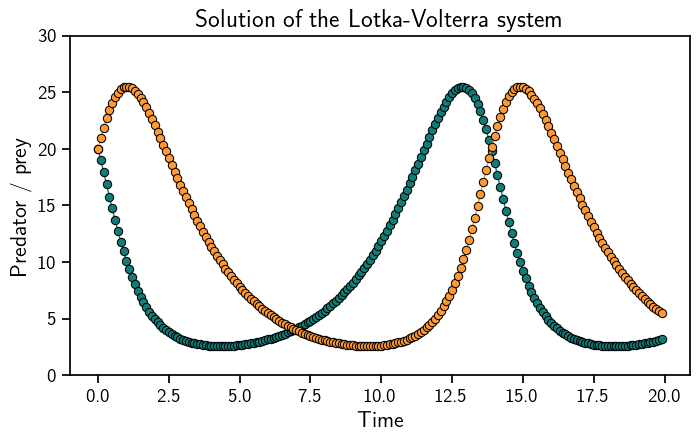

In [5]:
evalgrid = np.arange(lotka_volterra.t0, lotka_volterra.tmax, step=0.1)
sol = odesol(evalgrid)

plt.plot(evalgrid, sol.mean, "o-", linewidth=1)
plt.ylim((0, 30))
plt.xlabel("Time")
plt.ylabel("Predator / prey")
plt.title("Solution of the Lotka-Volterra system")
plt.show()

We can take the customisation further. For example, we can choose the EK1 as an approximation strategy and a piecewise constant diffusion model. Other options are available, too.

In [6]:
piecewise_constant = randprocs.markov.continuous.PiecewiseConstantDiffusion(t0=t0)
rk_init = diffeq.odefilter.initialization_routines.RungeKuttaInitialization()
ek1 = diffeq.odefilter.approx_strategies.EK1()

solver_ek1 = diffeq.odefilter.ODEFilter(
    steprule=adaptive_steps,
    prior_process=iwp,
    approx_strategy=ek1,
    diffusion_model=piecewise_constant,
)
odesol_ek1 = solver_ek1.solve(ivp=lotka_volterra)

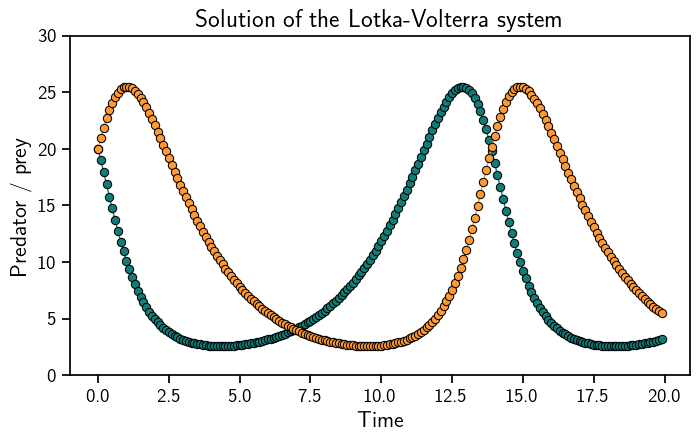

In [7]:
sol = odesol(evalgrid)

plt.plot(evalgrid, sol.mean, "o-", linewidth=1)
plt.ylim((0, 30))
plt.xlabel("Time")
plt.ylabel("Predator / prey")
plt.title("Solution of the Lotka-Volterra system")
plt.show()